# Download DataSet

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("wcukierski/enron-email-dataset")

print("Path to dataset files:", path)

100%|██████████| 358M/358M [00:14<00:00, 26.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/wcukierski/enron-email-dataset/versions/2


In [5]:
import os

data_path = "/root/.cache/kagglehub/datasets/wcukierski/enron-email-dataset/versions/2"
files = os.listdir(data_path)
print("Files in dataset:", files)

Files in dataset: ['emails.csv']


# Pre-processing

In [6]:
import pandas as pd
import re


emails_file = os.path.join(data_path, "emails.csv")
emails_df = pd.read_csv(emails_file)


print(emails_df.head())


def clean_email_content(message):
    message = re.sub(r'http\S+', '', message)
    message = re.sub(r'\d+', '', message)
    message = re.sub(r'[^\w\s]', '', message)
    message = message.lower()
    return message

emails_df['cleaned_message'] = emails_df['message'].apply(clean_email_content)
print("Cleaned email content preview:")
print(emails_df['cleaned_message'].head())


                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...
Cleaned email content preview:
0    messageid javamailevansthyme\ndate mon  may   ...
1    messageid javamailevansthyme\ndate fri  may   ...
2    messageid javamailevansthyme\ndate wed  oct   ...
3    messageid javamailevansthyme\ndate mon  oct   ...
4    messageid javamailevansthyme\ndate thu  aug   ...
Name: cleaned_message, dtype: object


# Labeling

In [7]:
def label_email(message):
    keywords = ['password', 'bank', 'credit', 'urgent', 'login']
    for keyword in keywords:
        if keyword in message.lower():
            return 1
    return 0

emails_df['label'] = emails_df['cleaned_message'].apply(label_email)
print(emails_df[['cleaned_message', 'label']].head())

                                     cleaned_message  label
0  messageid javamailevansthyme\ndate mon  may   ...      0
1  messageid javamailevansthyme\ndate fri  may   ...      0
2  messageid javamailevansthyme\ndate wed  oct   ...      0
3  messageid javamailevansthyme\ndate mon  oct   ...      0
4  messageid javamailevansthyme\ndate thu  aug   ...      0


# Split dataset

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    emails_df['cleaned_message'], emails_df['label'], test_size=0.2, random_state=42
)
print("Training and testing sets created.")

Training and testing sets created.


# Vectorization

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print("Text vectorization completed.")

Text vectorization completed.


# Create Model

In [10]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(random_state=42)
model.fit(X_train_vectorized, y_train)

print("Model training completed.")

Model training completed.


# Classification Report

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     89192
           1       0.99      0.82      0.90     14289

    accuracy                           0.97    103481
   macro avg       0.98      0.91      0.94    103481
weighted avg       0.97      0.97      0.97    103481

Accuracy: 0.9736569998357186


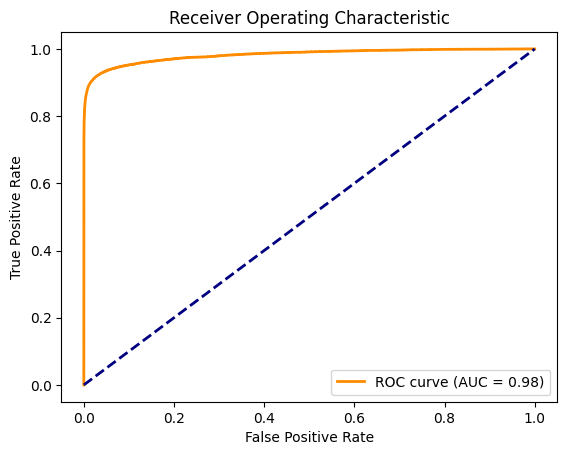

In [11]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt


y_pred = model.predict(X_test_vectorized)
y_pred_prob = model.predict_proba(X_test_vectorized)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Split for BERT

In [13]:
import torch
from torch.utils.data import Dataset

class EmailDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx])
        }


train_dataset = EmailDataset(train_encodings, y_train[:500].tolist())
test_dataset = EmailDataset(test_encodings, y_test[:100].tolist())


BERT

In [19]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import os


os.environ["WANDB_DISABLED"] = "true"

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
bert_model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)


train_encodings = tokenizer(list(X_train[:500]), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(list(X_test[:100]), truncation=True, padding=True, max_length=128, return_tensors="pt")


train_dataset = EmailDataset(train_encodings, y_train[:500].tolist())
test_dataset = EmailDataset(test_encodings, y_test[:100].tolist())

training_args = TrainingArguments(
    output_dir='./results', num_train_epochs=10, per_device_train_batch_size=8,
    eval_strategy="epoch", save_total_limit=2, learning_rate=2e-5, fp16=True
)

# Trainer
trainer = Trainer(
    model=bert_model, args=training_args,
    train_dataset=train_dataset, eval_dataset=test_dataset
)


trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,No log,0.385945
2,No log,0.407982
3,No log,0.379615
4,No log,0.374775
5,No log,0.459884
6,No log,0.375603
7,No log,0.396060
8,0.299200,0.455786
9,0.299200,0.459738
10,0.299200,0.453600


TrainOutput(global_step=630, training_loss=0.26233969037494964, metrics={'train_runtime': 4022.5737, 'train_samples_per_second': 1.243, 'train_steps_per_second': 0.157, 'total_flos': 165584248320000.0, 'train_loss': 0.26233969037494964, 'epoch': 10.0})

#Result Chart

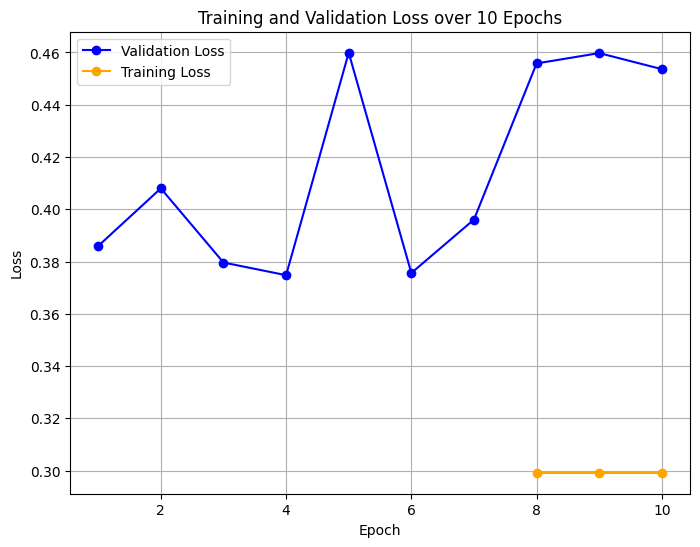

In [20]:
import matplotlib.pyplot as plt


epochs = list(range(1, 11))
training_loss = [None, None, None, None, None, None, None, 0.299200, 0.299200, 0.299200]  # مقادیر Training Loss
validation_loss = [0.385945, 0.407982, 0.379615, 0.374775, 0.459884, 0.375603, 0.396060, 0.455786, 0.459738, 0.453600]


training_epochs = [e for e, t in zip(epochs, training_loss) if t is not None]
training_loss_cleaned = [t for t in training_loss if t is not None]


plt.figure(figsize=(8, 6))


plt.plot(epochs, validation_loss, label="Validation Loss", marker='o', color='blue')


plt.plot(training_epochs, training_loss_cleaned, label="Training Loss", marker='o', color='orange')


plt.title("Training and Validation Loss over 10 Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Testing model

In [21]:
def predict_email(email_text):

    cleaned_email = clean_email_content(email_text)
    vectorized_email = vectorizer.transform([cleaned_email])
    prediction = model.predict(vectorized_email)
    return "Attack" if prediction[0] == 1 else "Not an Attack"


sample_email = "Please update your bank account details immediately to avoid account suspension."
print("Prediction:", predict_email(sample_email))

Prediction: Attack


# BERT prediction

In [22]:
import torch

def predict_email_with_bert(email_text):

    encoding = tokenizer(email_text, truncation=True, padding=True, max_length=512, return_tensors="pt")


    outputs = bert_model(**encoding)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()

    return "Attack" if prediction == 1 else "Not an Attack"

sample_email = "Your credit card has been compromised. Please click the link to secure your account."
print("Prediction:", predict_email_with_bert(sample_email))


Prediction: Not an Attack


# online attack test

In [23]:
while True:
    email_text = input("Enter an email text to test (or type 'exit' to quit): ")
    if email_text.lower() == 'exit':
        break
    print("Logistic Regression Prediction:", predict_email(email_text))
    print("BERT Prediction:", predict_email_with_bert(email_text))


Enter an email text to test (or type 'exit' to quit): Please update your bank account details immediately to avoid account suspension.
Logistic Regression Prediction: Attack
BERT Prediction: Not an Attack
Enter an email text to test (or type 'exit' to quit): exit
